In [1]:
# -*- coding: utf-8 -*-

import os
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import cProfile
import colorsys

In [2]:
def load_exposures(source_dir, channel=0):
    filenames = []
    exposure_times = []
    f = open(os.path.join(source_dir, 'image_list.txt'))
    for line in f:
        if (line[0] == '#'):
            continue
        (filename, exposure, *rest) = line.split()
        filenames += [filename]
        exposure_times += [exposure]
    
    img_list = [cv2.imread(os.path.join(source_dir, f), 1) for f in filenames]
    img_list = [img[:,:,channel] for img in img_list]
    exposure_times = np.array(exposure_times, dtype=np.float32)

    return (img_list, exposure_times)


In [129]:
def hdr_debvec(img_list, exposure_times):
    B = [math.log(e,2) for e in exposure_times]
    l = 10
    w = [z if z <= 0.5*255 else 255-z for z in range(256)]

    small_img = [cv2.resize(img, (10, 10)) for img in img_list]
    Z = [img.flatten() for img in small_img]

    #samples = [(random.randint(0, img_list[0].shape[0]-1), random.randint(0, img_list[0].shape[1]-1)) for i in range(50)]
    #Z = []
    #for img in img_list:
    #    Z += [[img[r[0]][r[1]] for r in samples]]
    
    plt.imshow(small_img[0], cmap='gray')
    #for i in samples:
    #    plt.scatter(i[1], i[0], c='r', s=10)
    plt.show()
    plt.imshow(small_img[1], cmap='gray')
    #for i in samples:
    #    plt.scatter(i[1], i[0], c='r', s=10)
    plt.show()
    plt.imshow(small_img[2], cmap='gray')
    #for i in samples:
    #    plt.scatter(i[1], i[0], c='r', s=10)
    plt.show()
     
    #print(np.shape(Z), samples)
    
    return response_curve_solver(Z, B, l, w)


In [106]:
def response_curve_solver(Z, B, l, w):
    n = 256
    A = np.zeros(shape=(np.size(Z, 0)*np.size(Z, 1)+n+1, n+np.size(Z, 1)), dtype=np.float32)
    b = np.zeros(shape=(np.size(A, 0), 1), dtype=np.float32)

    # Include the data−fitting equations
    k = 0
    for i in range(np.size(Z, 1)):
        for j in range(np.size(Z, 0)):
            z = Z[j][i]
            wij = w[z]
            A[k][z] = wij
            A[k][n+i] = -wij
            b[k] = wij*B[j]
            k += 1
    
    # Fix the curve by setting its middle value to 0
    A[k][128] = 1
    k += 1

    # Include the smoothness equations
    for i in range(n-1):
        A[k][i]   =    l*w[i+1]
        A[k][i+1] = -2*l*w[i+1]
        A[k][i+2] =    l*w[i+1]
        k += 1

    print(np.shape(A))
    print(np.shape(b))
    
    # Solve the system using SVD
    x = np.linalg.lstsq(A, b)[0]
    g = x[:256]
    lE = x[256:]

    return g, lE


In [107]:
def construct_radiance_map(g, Z, ln_t, w):
    acc_E = [0]*len(Z[0])
    ln_E = [0]*len(Z[0])
    
    pixels, imgs = len(Z[0]), len(Z)
    for i in range(pixels):
        acc_w = 0
        for j in range(imgs):
            z = Z[j][i]
            acc_E[i] += w[z]*(g[z] - ln_t[j])
            acc_w += w[z]
        ln_E[i] = acc_E[i]/acc_w if acc_w > 0 else acc_E[i]
        acc_w = 0
    
    return ln_E

In [108]:
def construct_hdr(img_list, response_curve, exposure_times):
    # Construct radiance map for each channels
    img_size = img_list[0][0].shape
    w = [z if z <= 0.5*255 else 255-z for z in range(256)]
    ln_t = np.log2(exposure_times)

    vfunc = np.vectorize(lambda x:math.exp(x))
    hdr = np.zeros((img_size[0], img_size[1], 3), 'float32')

    # construct radiance map for BGR channels
    for i in range(3):
        Z = [img.flatten().tolist() for img in img_list[i]]
        E = construct_radiance_map(response_curve[i], Z, ln_t, w)
        # Exponational each channels and reshape to 2D-matrix
        hdr[..., i] = np.reshape(vfunc(E), img_size)

    return hdr

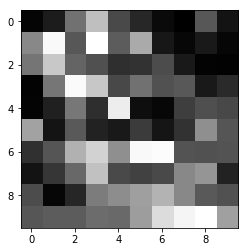

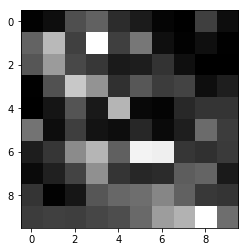

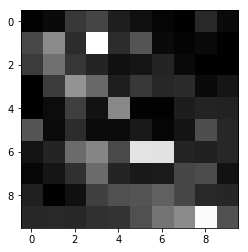

(1857, 356)
(1857, 1)


In [131]:
# Loading exposure images into a list
dirname = 'test'
img_list_b, exposure_times = load_exposures(dirname, 0)
img_list_g, exposure_times = load_exposures(dirname, 1)
img_list_r, exposure_times = load_exposures(dirname, 2)

gb, _ = hdr_debvec(img_list_b, exposure_times)
#gg, _ = hdr_debvec(img_list_g, exposure_times)
#gr, _ = hdr_debvec(img_list_r, exposure_times)


In [63]:
def alignment(img_list):
    median = [np.median(img) for img in img_list]
    binary_thres_img = [cv2.threshold(img_list[i], median[i], 255, cv2.THRESH_BINARY)[1] for i in range(len(img_list))]
    mask_img = [cv2.inRange(img_list[i], median[i]-20, median[i]+20) for i in range(len(img_list))]

    a=binary_thres_img[0]-binary_thres_img[1]
    s=0
    for x in np.nditer(a):
        s+=1 if x == 255 else 0
    print(s)

    for i in range(1, len(img_list)):
        offset = []
        diff = float('Inf')
        tmp_offset = []
        for y in range(-3, 4):
            for x in range(-3, 4):
                error = 0
                for row in range(img_list[0].shape[0]):
                    for col in range(img_list[0].shape[1]):
                        if x+col < 0 or y+row < 0 or x+col >= img_list[0].shape[1] or y+row >= img_list[0].shape[1]:
                            continue
                        if mask_img[0][row][col] == 255:
                            continue
                        error += 1 if binary_thres_img[0][row][col] != binary_thres_img[i][row+y][col+x] else 0
                if error < diff:
                    tmp_offset = [y, x]
                    diff = error
                print([y, x], error)
        offset += [tmp_offset]
        print('-----------'+str(offset[-1]))


In [95]:
def median_threshold_bitmap_alignment(img_list):
    median = [np.median(img) for img in img_list]
    binary_thres_img = [cv2.threshold(img_list[i], median[i], 255, cv2.THRESH_BINARY)[1] for i in range(len(img_list))]
    mask_img = [cv2.inRange(img_list[i], median[i]-20, median[i]+20) for i in range(len(img_list))]
    
    
    print(median,binary_thres_img[0])
    plt.imshow(mask_img[0], cmap='gray')
    plt.show()
    
    max_offset = np.max(img_list[0].shape)
    levels = 5
    print(max_offset, levels)
    print(img_list[0].shape)

    global_offset = []
    for i in range(0, len(img_list)):
        offset = [[0,0]]
        for level in range(levels, -1, -1):
            scaled_img = cv2.resize(binary_thres_img[i], (0, 0), fx=1/(2**level), fy=1/(2**level))
            ground_img = cv2.resize(binary_thres_img[0], (0, 0), fx=1/(2**level), fy=1/(2**level))
            ground_mask = cv2.resize(mask_img[0], (0, 0), fx=1/(2**level), fy=1/(2**level))
            mask = cv2.resize(mask_img[i], (0, 0), fx=1/(2**level), fy=1/(2**level))
            
            
            #cv2.imwrite('mtb-level_'+str(level)+'.jpg',ground_img)
            #cv2.imwrite('mask-level_'+str(level)+'.jpg',ground_mask)
            level_offset = [0, 0]
            diff = float('Inf')
            for y in [-1, 0, 1]:
                for x in [-1, 0, 1]:
                    off = [offset[-1][0]*2+y, offset[-1][1]*2+x]
                    error = 0
                    for row in range(ground_img.shape[0]):
                        for col in range(ground_img.shape[1]):
                            if off[1]+col < 0 or off[0]+row < 0 or off[1]+col >= ground_img.shape[1] or off[0]+row >= ground_img.shape[1]:
                                continue
                            if ground_mask[row][col] == 255:
                                continue
                            error += 1 if ground_img[row][col] != scaled_img[y+off[0]][x+off[1]] else 0
                    if error < diff:
                        level_offset = off
                        diff = error
                    print(off, error)
            offset += [level_offset]
            print('-----------'+str(offset[-1]))
        global_offset += [offset[-1]]
        #global_offset += [weighted_offset]
              
        print(offset, global_offset)
    
    return global_offset

[141.0, 9.0] [[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


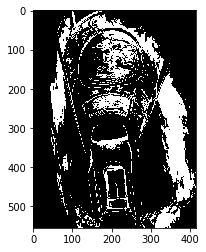

555 5
(555, 415)


[]

In [96]:
# MTB implementation

median_threshold_bitmap_alignment(img_list_g)

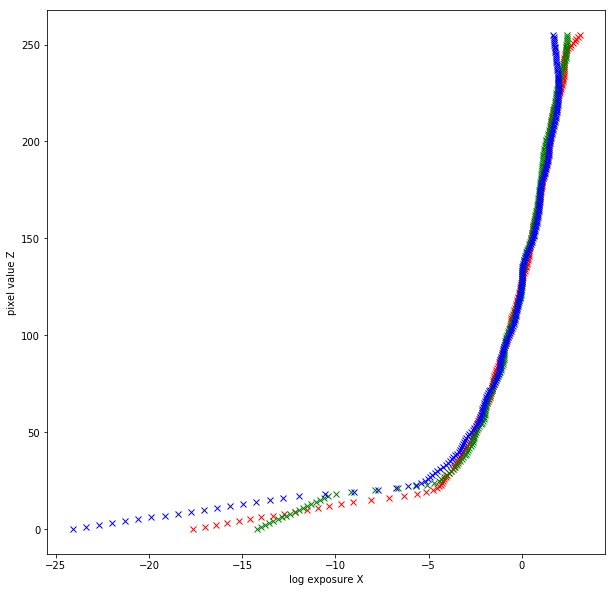

In [124]:
plt.figure(figsize=(10,10))
plt.plot(gr,range(256), 'rx')
plt.plot(gg,range(256), 'gx')
plt.plot(gb,range(256), 'bx')
plt.ylabel('pixel value Z')
plt.xlabel('log exposure X')
plt.show()

In [281]:
hdr = construct_hdr([img_list_b, img_list_g, img_list_r], [gb, gg, gr], exposure_times)

In [282]:
print(np.log(hdr).max())

9.90856


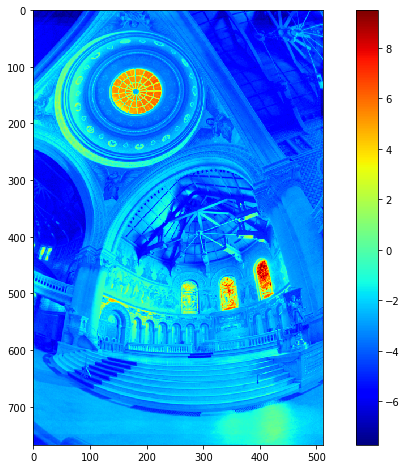

In [286]:
# Show false-color Radiance map (log value)
plt.figure(figsize=(12, 8))
plt.imshow(np.log(cv2.cvtColor(hdr, cv2.COLOR_BGR2GRAY)), cmap='jet')
plt.colorbar()
plt.show()

In [278]:
print(hdr.shape, hdr.dtype)
image = np.zeros((hdr.shape[0], hdr.shape[1], 3), 'float32')
image[..., 0] = hdr[..., 2]
image[..., 1] = hdr[..., 1]
image[..., 2] = hdr[..., 0]

f = open("xxx.hdr", "wb")
f.write(b"#?RADIANCE\n# Made with Python & Numpy\nFORMAT=32-bit_rle_rgbe\n\n")
header = "-Y {0} +X {1}\n".format(image.shape[0], image.shape[1]) 
f.write(bytes(header, encoding='utf-8'))

brightest = np.maximum(np.maximum(image[...,0], image[...,1]), image[...,2])
mantissa = np.zeros_like(brightest)
exponent = np.zeros_like(brightest)
np.frexp(brightest, mantissa, exponent)
scaled_mantissa = mantissa * 256.0 / brightest
rgbe = np.zeros((image.shape[0], image.shape[1], 4), dtype=np.uint8)
rgbe[...,0:3] = np.around(image[...,0:3] * scaled_mantissa[...,None])
rgbe[...,3] = np.around(exponent + 128)

rgbe.flatten().tofile(f)
f.close()

(768, 512, 3) float32
